In [4]:
import sys
from pathlib import Path
import pandas as pd


ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))   


try:
    df  
    print("Using df from memory:", df.shape)
except NameError:
    TRAIN_PATH = ROOT / "data" / "train.csv"
    print("Reading:", TRAIN_PATH.resolve())
    assert TRAIN_PATH.exists(), "train.csv not found in data/ folder."
    df = pd.read_csv(TRAIN_PATH)
    print("Loaded df:", df.shape)

from src.clean import basic_clean
from src.features import build_min_features

df_clean = basic_clean(df, impute="median")
print("After cleaning:", df_clean.shape)

df_feat, FEATURES = build_min_features(df_clean, include_bucket=True)
print("Num features:", len(FEATURES))
print("FEATURES:", FEATURES)

TARGET = "target"
assert TARGET in df_feat.columns, "target column not found after cleaning."
assert len(FEATURES) > 0, "no FEATURES were selected."

preview_cols = FEATURES + [TARGET]
display(df_feat[preview_cols].head(5))

GROUP_COL = "date_id" if "date_id" in df_feat.columns else None
print("Group by:", GROUP_COL or "(none)")


Reading: /Users/krithiktoure/Desktop/DS Project 1/data/train.csv
Loaded df: (5237980, 17)
After cleaning: (5237892, 17)
Num features: 13
FEATURES: ['seconds_in_bucket', 'sec_bucket_group', 'bid_ask_spread', 'mid_price', 'signed_imbalance', 'near_price_minus_ref', 'far_price_minus_ref', 'matched_size', 'imbalance_size', 'bid_size', 'ask_size', 'reference_price', 'wap']


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,target
0,0,0,0.000214,0.999919,3180602.69,0.000077,0.000071,13380276.64,3180602.69,60651.50,8493.03,0.999812,1.000000,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-0.000137,-0.000143,15261106.63,1299772.70,13996.50,23519.16,1.000026,0.999892,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.000030,-0.000036,15261106.63,1299772.70,4665.50,12131.60,0.999919,0.999842,4.220009
3,30,0,0.000107,1.000080,1299772.70,-0.000244,-0.000250,15261106.63,1299772.70,55998.00,46203.30,1.000133,1.000085,5.450249
4,40,0,0.000214,1.000348,1218204.43,-0.000566,-0.000572,15342674.90,1218204.43,14655.95,26610.45,1.000455,1.000317,3.169775


Group by: date_id


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_601/774911821.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))


Training on rows: 721500 (DEBUG: True )
Using model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 13
[LightGBM] [Info] Start training from score -0.028767


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 LightGBM MAE: 6.40470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 481500, number of used features: 13
[LightGBM] [Info] Start training from score -0.025586


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 LightGBM MAE: 6.30818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 481500, number of used features: 13
[LightGBM] [Info] Start training from score -0.044745


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 LightGBM MAE: 6.33331

FAST CV MAE: 6.34873 ± 0.04089 (3 folds, DEBUG=True)


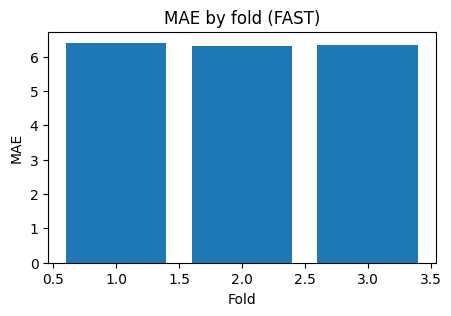

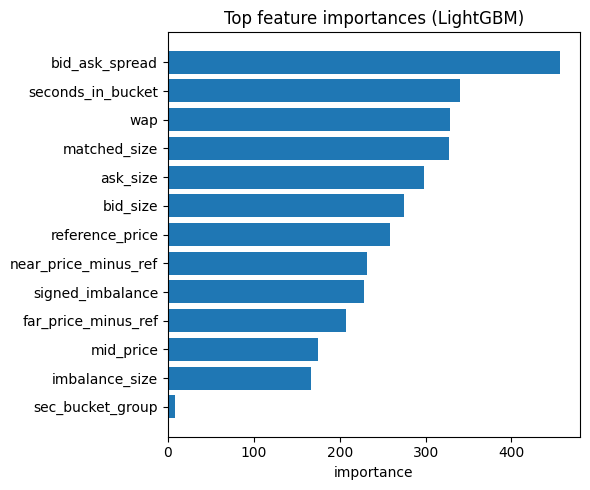

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error


DEBUG = True                 
SAMPLE_PER_DAY = 1500        
N_SPLITS = 3                
SEED = 42


if DEBUG and "date_id" in df_feat.columns:
    np.random.seed(SEED)
    idx = (
        df_feat.groupby("date_id", group_keys=False)
               .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))
               .index
    )
    df_small = df_feat.loc[idx].reset_index(drop=True)
else:
    df_small = df_feat

print("Training on rows:", len(df_small), "(DEBUG:", DEBUG, ")")

# --- 3) choose a fast model (LightGBM if available; else HistGBR; else RF) ---
MODEL_NAME = None
try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    def make_model():
        return LGBMRegressor(
            n_estimators=1500,        # we'll stop early, so OK if big
            learning_rate=0.07,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED
        )
    MODEL_NAME = "LightGBM"
except Exception:
    try:
        from sklearn.ensemble import HistGradientBoostingRegressor
        def make_model():
            # fast, built-in gradient boosting with early stopping
            return HistGradientBoostingRegressor(
                learning_rate=0.1,
                max_depth=None,
                max_iter=500,
                early_stopping=True,
                random_state=SEED
            )
        MODEL_NAME = "HistGBR"
    except Exception:
        from sklearn.ensemble import RandomForestRegressor
        def make_model():
            return RandomForestRegressor(
                n_estimators=120,      # smaller to keep it quick
                n_jobs=-1,
                random_state=SEED
            )
        MODEL_NAME = "RandomForest"

print("Using model:", MODEL_NAME)

# --- 4) set up data arrays ---
X = df_small[FEATURES].values
y = df_small[TARGET].values
groups = df_small["date_id"].values if "date_id" in df_small.columns else None

cv = GroupKFold(n_splits=N_SPLITS) if groups is not None else KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_mae = []
models = []

# --- 5) cross-validation loop (with early stopping when possible) ---
for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups), 1):
    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_va, y_va = X[va_idx], y[va_idx]

    model = make_model()

    if MODEL_NAME == "LightGBM":
        # use LightGBM's built-in early stopping
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
        )
    else:
        # other models don't support eval_set the same way; just fit
        model.fit(X_tr, y_tr)

    pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, pred)
    fold_mae.append(mae)
    models.append(model)
    print(f"Fold {fold} {MODEL_NAME} MAE: {mae:.5f}")

cv_mean, cv_std = float(np.mean(fold_mae)), float(np.std(fold_mae))
print(f"\nFAST CV MAE: {cv_mean:.5f} ± {cv_std:.5f} ({N_SPLITS} folds, DEBUG={DEBUG})")

# --- 6) quick bars for fold MAE ---
plt.figure(figsize=(5,3))
plt.bar(range(1, N_SPLITS+1), fold_mae)
plt.xlabel("Fold"); plt.ylabel("MAE"); plt.title("MAE by fold (FAST)")
plt.show()

# --- 7) feature importances if present ---
if hasattr(models[0], "feature_importances_"):
    importances = models[0].feature_importances_
    order = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(6,5))
    plt.barh([FEATURES[i] for i in order][::-1], importances[order][::-1])
    plt.title(f"Top feature importances ({MODEL_NAME})")
    plt.xlabel("importance")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not expose feature importances (that’s OK).")


In [6]:
from pathlib import Path         
import json                      
import numpy as np               
import joblib                    

# 1) make sure the artifacts/ folder exists
ARTIFACTS = ROOT / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)


best_idx = int(np.argmin(fold_mae))   
best_model = models[best_idx]         

# 3) choose where to save the model file (example: artifacts/lightgbm_best_fold3.pkl)
model_path = ARTIFACTS / f"{MODEL_NAME.lower()}_best_fold{best_idx+1}.pkl"
joblib.dump(best_model, model_path)   # write the model to disk

# 4) save the FEATURES list we trained on (so we know the exact columns later)
features_path = ARTIFACTS / "features.json"
with open(features_path, "w") as f:
    json.dump(FEATURES, f)            # write as JSON text

# 5) save a tiny CV report (so we remember scores/settings)
meta = {
    "model": MODEL_NAME,
    "best_fold": best_idx + 1,        # human-friendly 1..K
    "fold_mae": [float(x) for x in fold_mae],
    "cv_mae_mean": float(cv_mean),
    "cv_mae_std": float(cv_std),
    "n_features": int(len(FEATURES))
}
meta_path = ARTIFACTS / "cv_meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

# 6) quick sanity: load the model back and make 3 tiny predictions
loaded_model = joblib.load(model_path)
tiny_pred = loaded_model.predict(df_feat[FEATURES].values[:3])

print("Saved model   ->", model_path.name)
print("Saved features->", features_path.name)
print("Saved report  ->", meta_path.name)
print("Tiny preds    ->", tiny_pred[:3])


Saved model   -> lightgbm_best_fold2.pkl
Saved features-> features.json
Saved report  -> cv_meta.json
Tiny preds    -> [-0.72173744  0.13682579  0.41063678]


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Analyzing rows: 721500


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


OOF MAE: 6.34885 (should be ~ CV mean 6.34873)
Worst 5 days by MAE:


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_601/1029771862.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g[TARGET], g["oof_pred"]))


date_id
96     13.481967
122    12.561627
119    11.220523
83     11.139949
346    10.528481
Name: mae, dtype: float64

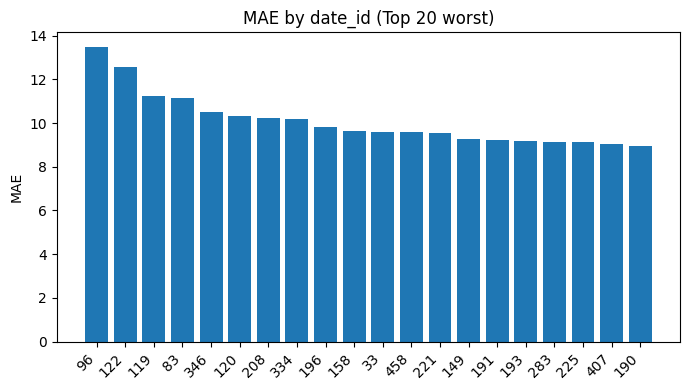

Worst 10 stocks by MAE:


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_601/1029771862.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g[TARGET], g["oof_pred"]))


stock_id
82     14.346972
86     13.137071
31     12.509807
174    12.474872
92     12.086352
100    12.028200
129    11.971530
158    11.515826
70     10.937603
85     10.819191
Name: mae, dtype: float64

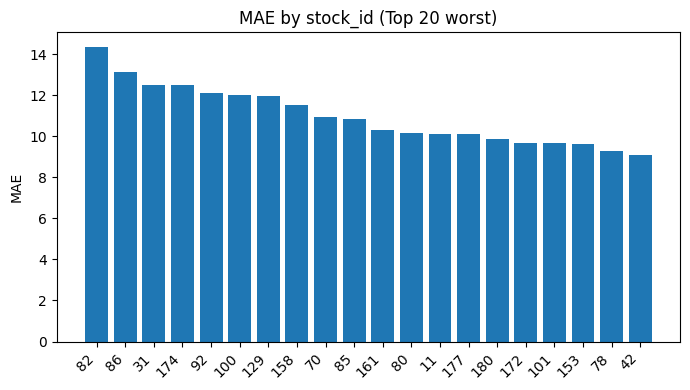

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error


df_used = df_small if 'df_small' in globals() else df_feat
print("Analyzing rows:", len(df_used))


X = df_used[FEATURES].values
y = df_used[TARGET].values
groups_used = df_used["date_id"].values if "date_id" in df_used.columns else None
n_folds = len(models)                     


cv = GroupKFold(n_splits=n_folds) if groups_used is not None else KFold(n_splits=n_folds, shuffle=True, random_state=SEED)


oof_pred = np.full(shape=len(df_used), fill_value=np.nan, dtype=float)


for i, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups_used)):
    fold_model = models[i]               
    oof_pred[va_idx] = fold_model.predict(X[va_idx])


oof_mae = mean_absolute_error(y[~np.isnan(oof_pred)], oof_pred[~np.isnan(oof_pred)])
print(f"OOF MAE: {oof_mae:.5f} (should be ~ CV mean {cv_mean:.5f})")


df_eval = df_used.copy()
df_eval["oof_pred"] = oof_pred

if "date_id" in df_eval.columns:
    by_day = (
        df_eval.dropna(subset=["oof_pred"])
               .groupby("date_id", observed=True)
               .apply(lambda g: mean_absolute_error(g[TARGET], g["oof_pred"]))
               .rename("mae")
               .sort_values(ascending=False)
    )
    print("Worst 5 days by MAE:")
    display(by_day.head(5))

    # plot top 20 worst days
    plt.figure(figsize=(7,4))
    worst_days = by_day.head(20)
    plt.bar(worst_days.index.astype(str), worst_days.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("MAE")
    plt.title("MAE by date_id (Top 20 worst)")
    plt.tight_layout()
    plt.show()


if "stock_id" in df_eval.columns:
    by_stock = (
        df_eval.dropna(subset=["oof_pred"])
               .groupby("stock_id", observed=True)
               .apply(lambda g: mean_absolute_error(g[TARGET], g["oof_pred"]))
               .rename("mae")
               .sort_values(ascending=False)
    )
    print("Worst 10 stocks by MAE:")
    display(by_stock.head(10))

  
    plt.figure(figsize=(7,4))
    worst_stocks = by_stock.head(20)
    plt.bar(worst_stocks.index.astype(str), worst_stocks.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("MAE")
    plt.title("MAE by stock_id (Top 20 worst)")
    plt.tight_layout()
    plt.show()
